In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


# Generate fake data sets
(used in both q2 and q3)

In [14]:
class ds_hw2: 
    """
    dataset with binary class-conditional gaussian distribution
    (with equal covariance for both class)
    """
    def __init__(self,numSamplesClassPlus = 10, numSamplesClassNeg = 10, \
                 mean_plus= np.array([-0.7, 0]),\
                 mean_neg = np.array([0.7, 0]), \
                 cov = np.array([[1, 1], [1, 2]])\
                ):
        self.mean_plus = mean_plus
        self.mean_neg = mean_neg
        self.cov = cov
        
        self.numSamplesClassPlus = numSamplesClassPlus
        self.numSamplesClassNeg= numSamplesClassNeg
        # generate the data
        rng = np.random.default_rng(32345)
        self.X_plus = rng.multivariate_normal(mean_plus, cov, numSamplesClassPlus)
        self.X_neg  = rng.multivariate_normal(mean_neg, cov, numSamplesClassNeg)
    def get_truth_para(self):
        return [self.mean_plus,self.mean_neg,self.cov,self.cov]
    def get_X_splitted(self):
        """
        returns a concatenated list, first class "plus" then "neg"
        """
        return [self.X_plus,self.X_neg]
    def get_X_merged(self):
        return np.concatenate([self.X_plus,self.X_neg],axis=0)
    def get_y_merged(self):
        return np.array([*[1]*self.numSamplesClassPlus, *[-1]*self.numSamplesClassNeg],dtype=np.int)
    def reportAccuracy(self, y_pred_merged,verbose=False): 
        """
        compare your prediction with the truth
        """
        if verbose:
            print(y_pred_merged)
            print(self.get_y_merged())
        isCorrect = np.equal(y_pred_merged,self.get_y_merged())

        accuracy_overall = np.mean(isCorrect)
        numSamplesTot = self.numSamplesClassPlus+self.numSamplesClassNeg
        print("   the (training) accuracy for this model with {:4d} samples is: ".format(numSamplesTot),\
                  "{:.3f} (overall)".format(accuracy_overall) 
             )
        return accuracy_overall
    def genDictForStan(self):
        return {'N_po': self.numSamplesClassPlus, 'N_ng': self.numSamplesClassNeg,\
        'Dim': 2, 'x_po': self.X_plus, 'x_ng': self.X_neg}

In [15]:
ds10 = ds_hw2(10,10)
# print(ds10.get_X_merged())
# ds10.reportAccuracy(np.concatenate([np.array([1]*10),np.array([-1]*10)],axis=0))
ds100 = ds_hw2(100,100)
ds = [ds10,ds100]

# Problem 2 (native Python implementation of QDA/LDA)

In [4]:
class QDA_bin_2D: 
    """
    a generative binary classifier QDA in R^2 (including LDA as a special case)
    """
    
    def __init__(self,\
                 mean_plus=None, mean_neg=None,\
                 cov_plus =None, cov_neg =None,\
                 pi_plus = 0.5
                ):
        """
        inputs:
        ---------------
        mean_plus:  2-array (optional)
            the mean of class "plus" in R^2
        mean_neg:   2-array (optional)
            the mean of class "neg" in R^2
        cov_plus:   2x2-array (optional)
            the covariance matrix of the likelihood of class "plus"
            (should be positively definite, shall be symmetric)
        cov_neg:    2x2-array (optional)
            the covariance matrix of the likelihood of class "neg"
            (should be positively definite, shall be symmetric)
        pi_plus:    real (optional)
            the prior probability of class "plus"
            (should be within 0 and 1)
        """
        # -------------------------------
        # about the likelihood function
        # ------------------------------
        self.mean_plus = mean_plus
        self.mean_neg = mean_neg
        self.cov_plus = cov_plus 
        self.cov_neg = cov_neg
        
        # ------------------------------
        # about the prior
        # ------------------------------
        self.pi_plus = pi_plus

    def fit(self,X,y,mean_plus=None,mean_neg=None,cov_plus=None, cov_neg=None,verbose=False):
        """
        fit the parameters with MLE given N i.i.d. samples,
        at the same time a setter method
        
        inputs
        ---------------------------
        X:   Nx2 array
            each row corresponds to the coordinate of a sample
        y:   N array
            each element shall be either 1 (considered as class "plus") 
            or -1 (considered as class "negative")
        """
        if verbose:
            print("before fitting:...")
            self.printPara()
        
        # Seperate data into two classes
        X_plus = X[y == 1]
        X_neg = X[y == -1]
        
        # the Maximum Likelihood estimates
        if mean_plus is None:
            self.mean_plus = np.mean(X_plus, axis=0) 
        else:
            self.mean_plus = mean_plus
        if mean_neg is None:
            self.mean_neg = np.mean(X_neg, axis=0) 
        else:
            self.mean_neg = mean_neg
        if cov_plus is None:
            self.cov_plus = np.matmul((X_plus-self.mean_plus).T, X_plus-self.mean_plus) / X_plus.shape[0]
        else:
            self.cov_plus = cov_plus
        if cov_neg is None:
            self.cov_neg  = np.matmul((X_neg-self.mean_neg).T, X_neg-self.mean_neg) / X_neg.shape[0]
        else:
            self.cov_neg = cov_neg
        
        # Prior "fit" using MLE
        self.pi_plus = X_plus.shape[0] / (X.shape[0]) 
        
        if verbose:
            print("after fitting:...")
            self.printPara()
            print(" with the following discriminate parameters")
            print(self.calcDiscrm())
    def printPara(self):
        print(" mean_plus:")
        print(self.mean_plus)
        print(" mean_neg:")
        print(self.mean_neg)
        print(" covariance matrix of class plus:")
        print(self.cov_plus)
        print(" covariance matrix of class neg:")
        print(self.cov_neg)
        print(" prior of class plus:")
        print(self.pi_plus)
    def calcDiscrm(self, verbose = False):
        """
        calculate the decision discriminant parameters A,b,c
        if x'Ax + b'x + c > 0, then the model predicts x belongs to class
        
        returns
        -------------------------
        A:  2x2 (symmetric)
        
        see also
        ------------------
        QDA_bin_2D.predict
        
        """
        # precision matrix (the inverse of the respective covariance matrix)
        covariance_plus_inv = np.linalg.inv(self.cov_plus)
        covariance_minus_inv = np.linalg.inv(self.cov_neg)
        # A, b, c
        A = covariance_minus_inv - covariance_plus_inv
        b = 2*(self.mean_plus@covariance_plus_inv - self.mean_neg@covariance_minus_inv)
        c = self.mean_neg@covariance_minus_inv@self.mean_neg \
            - self.mean_plus@covariance_plus_inv@self.mean_plus \
            -2*(np.log((1-self.pi_plus)*np.sqrt(np.linalg.det(self.cov_plus))) \
                   - np.log(self.pi_plus*np.sqrt(np.linalg.det(self.cov_neg)))\
               )
        if verbose:
            print("A:", A)
            print("b:", b)
            print("c:", c)
        return A,b,c
        
    def predict(self,X):
        """
        classify/ predict the class of N input(s)
        
        inputs
        ---------------------------
        X:   Nx2 array
            each row corresponds to the coordinate of a sample
        
        returns
        --------------------------
        y_hat:   N array
            each element will be 
            either 1 (considered as class "plus") 
            or -1 (considered as class "negative")
        """
        # print("---------- Start Predicting... ----------")
        A,b,c = self.calcDiscrm()
        y_hat = np.zeros(X.shape[0],dtype=np.int)
        #print(x.shape)
        for i in range(X.shape[0]):
            y_hat[i] = np.sign(X[i]@A@X[i].T + X[i]@b + c)
        return y_hat

## Task 2c --- LDA with cheating (with plots)
cheating in the sense: we do not use any estimates but the "true" parameters that generates the data

note: we do not use the "fit" method at all...

### Plotting functions (needed for task 2c)

In [17]:
def plot_samples(axes, x_plus, x_minus):
    axes.scatter(x_plus[:,0], x_plus[:,1], marker='o', color='#99d594', label='$class +$')
    axes.scatter(x_minus[:, 0], x_minus[:, 1], marker='x', color='firebrick', label='$class -$')
    axes.grid(linestyle='--')
    axes.set_title(str(x_plus.shape[0]*2) + " samples in total")
    axes.legend(loc = 'upper left')
    axes.set_xlabel('$x_1$',fontsize="large")
    axes.set_ylabel('$x_2$',fontsize="large")
def plot_boundary(axes, w, b):
    """
    this Ad-hoc implementation only permits LDA (assuming the decision boundary not being a straight line)
    """
    a = -w[0]/w[1]
    b = -b/w[1]
    
    min_x, max_x, min_y, max_y = axes.axis()
    axes.axis([min_x, max_x, min_y, max_y])
    line_x = np.array([min_x, max_x])
    line_y = a*line_x+b
    axes.plot(line_x, line_y, linestyle='--', color='y', label='LDA decision surface')

  Task 2c:  LDA (cheating mode)
   the (training) accuracy for this model with   20 samples is:  0.900 (overall)
     note: the plot of the data & the decision surface can be inspected from the figure below:
   the (training) accuracy for this model with  200 samples is:  0.860 (overall)
     note: the plot of the data & the decision surface can be inspected from the figure below:


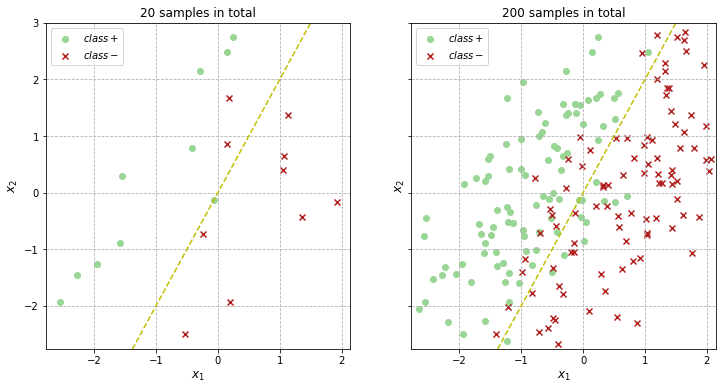

In [18]:
print("=================================")
print("  Task 2c:  LDA (cheating mode)")

fig, axesList = plt.subplots(1, 2, figsize=(12,6) ,sharex='all', sharey='all')

for data, subplotaxis in zip(ds,axesList):
    clf = QDA_bin_2D(*data.get_truth_para()) # LDA !!!
    # by cheating, there is no need to "tune" !!!
    y_hat = clf.predict(data.get_X_merged())
    data.reportAccuracy(y_hat,verbose=False)
    print("     note: the plot of the data & the decision surface can be inspected from the figure below:")
    
    # plot the samples on the corresponding subplot
    plot_samples(subplotaxis, *data.get_X_splitted())
    # plot the decision boundary of the QDA
    _, b,c = clf.calcDiscrm(); 
    plot_boundary(subplotaxis, b, c)

plt.savefig('Ex2_Task2c_plot_LDA.pdf')

## Task 2d --- QDA with some cheating
cheating in the sense: we do not use the MLE for the mean but the "true" parameters that generates the data
(but the covariance parameters have to be estimated by MLE)

In [19]:
print("=================================")
print("  Task 2d:  QDA (cheating on mean)")

for data, subplotaxis in zip(ds,axesList):
    clf = QDA_bin_2D()
    X = data.get_X_merged()
    y = data.get_y_merged()
    clf.fit(X,y, *data.get_truth_para()[:2])
    y_hat = clf.predict(X)
    data.reportAccuracy(y_hat)

  Task 2d:  QDA (cheating on mean)
   the (training) accuracy for this model with   20 samples is:  0.850 (overall)
   the (training) accuracy for this model with  200 samples is:  0.850 (overall)


## Task 2e --- QDA without cheating

In [20]:
print("=================================")
print("  Task 2e:  QDA (with ML inference)")

for data, subplotaxis in zip(ds,axesList):
    clf = QDA_bin_2D()
    X = data.get_X_merged()
    y = data.get_y_merged()
    clf.fit(X,y)
    y_hat = clf.predict(X)
    data.reportAccuracy(y_hat)

  Task 2e:  QDA (with ML inference)
   the (training) accuracy for this model with   20 samples is:  0.900 (overall)
   the (training) accuracy for this model with  200 samples is:  0.850 (overall)


# Problem 3

In [9]:
import pystan

## LDA Model with Stan
(i.e. same covariance for both classes' likelihood)

In [10]:
mdl_stan_LDA_code = """
    data {
      int<lower=1> N_po; // num of samples with          
      int<lower=1> N_ng;          
      int<lower=1> Dim;          
      vector[Dim] x_po[N_po];          
      vector[Dim] x_ng[N_ng];          
    }
    parameters {
      vector[Dim] mu_1;             
      vector[Dim] mu_2;             
      
      cov_matrix[Dim] sigma;
    }
    model {
      
      // prior
      mu_1 ~ normal(0, 2);
      mu_2 ~ normal(0, 2);
      
      // likelihood functions
      x_po ~ multi_normal(mu_1, sigma);
      x_ng ~ multi_normal(mu_2, sigma);
    }
    """

# compile the model ...
mdl_stan_LDA = pystan.StanModel(model_code=mdl_stan_LDA_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d63e45cd01664476418ac6b8bee25f0a NOW.


In [21]:
# now fits to the datasets
print("=================================")
print("  Task 3:  LDA (with stan)")
for data in ds:
    fit = mdl_stan_LDA.sampling(data=data.genDictForStan())
    paras = fit.extract()
    predictor = QDA_bin_2D(\
                    mean_plus =paras['mu_1'].mean(axis = 0), \
                    mean_neg=paras['mu_2'].mean(axis = 0),\
                    cov_plus=paras['sigma'].mean(axis = 0), \
                    cov_neg =paras['sigma'].mean(axis = 0)\
                )
    y_hat = predictor.predict(data.get_X_merged())
    data.reportAccuracy(y_hat)

  Task 3:  LDA (with stan)
   the (training) accuracy for this model with   20 samples is:  0.900 (overall)
   the (training) accuracy for this model with  200 samples is:  0.850 (overall)


## QDA Model with Stan

In [12]:
mdl_stan_QDA_code = """
    data {
      int<lower=1> N_po; // num of samples with          
      int<lower=1> N_ng;          
      int<lower=1> Dim;          
      vector[Dim] x_po[N_po];          
      vector[Dim] x_ng[N_ng];          
    }
    parameters {
      vector[Dim] mu_1;             
      vector[Dim] mu_2;             
      
      cov_matrix[Dim] sigma_1;
      cov_matrix[Dim] sigma_2;
    }
    model {
      
      // prior
      mu_1 ~ normal(0, 2);
      mu_2 ~ normal(0, 2);
      
      // likelihood functions
      x_po ~ multi_normal(mu_1, sigma_1);
      x_ng ~ multi_normal(mu_2, sigma_2);
    }
    """
# compile the model ...
mdl_stan_QDA = pystan.StanModel(model_code=mdl_stan_QDA_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c5a81fcd0d710540de15e036a0ca41b9 NOW.


In [22]:
# now fits to the datasets
print("=================================")
print("  Task 3:  QDA (with stan)")
for data in ds:
    fit = mdl_stan_QDA.sampling(data=data.genDictForStan())
    paras = fit.extract()
    predictor = QDA_bin_2D(\
                    mean_plus =paras['mu_1'].mean(axis = 0), \
                    mean_neg=paras['mu_2'].mean(axis = 0),\
                    cov_plus=paras['sigma_1'].mean(axis = 0), \
                    cov_neg =paras['sigma_2'].mean(axis = 0)\
                )
    y_hat = predictor.predict(data.get_X_merged())
    data.reportAccuracy(y_hat)

  Task 3:  QDA (with stan)
   the (training) accuracy for this model with   20 samples is:  0.900 (overall)
   the (training) accuracy for this model with  200 samples is:  0.850 (overall)
